## Repeatable, Parallel Model Training with AutoML
  
In this notebook, you will use Azure Machine learning to create a repeatable, scaleable AUTOML model training framework. An AutoML job will run for each Brand,Store combination to identify the best feature engineering + algorithm combination. In Addition to the key concepts in [1_training_pipeline](./1_training_pipeline.ipynb), this notebook also covers Azure AutoML. 
  
**Azure AutoML**
   - During training, Azure Machine Learning creates many pipelines in parallel that try different algorithms and parameters for you. The service iterates through ML algorithms paired with feature selections, where each iteration produces a model with a training score. The better the score for the metric you want to optimize for, the better the model is considered to "fit" your data. It stops once it hits the exit criteria defined in the experiment.
   - [More information on Azure AutoML here](https://learn.microsoft.com/en-us/azure/machine-learning/concept-automated-ml?view=azureml-api-2)

In [7]:
# import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient, Input, Output, load_component
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml.parallel import parallel_run_function, RunFunction
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import os
import yaml

In [2]:
# Initialize ML Client
load_dotenv(find_dotenv(), override=True)

# authenticate
credential = DefaultAzureCredential(tenantid=os.environ.get('TENANT_ID'))

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

### Prepare, Define, and Run Training Pipeline

In [3]:
# Load data preparation component
partition_data = load_component(source="../src/components/partition_data/partition_data.yaml")

In [ ]:
# TODO: Might need to use automl partition component...

In [25]:
# get registry for all components
ml_client_registry = MLClient(credential=credential, registry_name="azureml")

# Load AutoML Training Component
train_component_from_registry = ml_client_registry.components.get(
    name="automl_many_models_training",
    label="latest",
)

print(f"Many models training component version: {train_component_from_registry.version}\n---")

partition_component_from_registry = ml_client_registry.components.get(
    name="automl_tabular_data_partitioning", label="latest"
)
print(f"Data partitioning component version: {partition_component_from_registry.version}\n---")

Many models training component version: 0.0.3
---
Data partitioning component version: 0.0.3
---


In [5]:
# Acess data asset
data_name = "oj-sim-sales-train"
train_data_asset = ml_client.data.get(data_name, label='latest')
print(train_data_asset.path)

azureml://subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/many-models-rg/workspaces/many-models-aml/datastores/workspaceblobstore/paths/LocalUpload/eabbea2d8b14c97a278f2f297b333403/train_subset.csv


In [8]:
# Define compute target (created in setup notebook)
cpu_compute_target = "mm-cpu-cluster"

# Define runtime environment
custom_env_name = "mm-remote-env-py310"

# Define tracking URI
azureml_tracking_uri = ml_client.workspaces.get(ml_client.workspace_name).mlflow_tracking_uri

In [52]:
# Set some parameters to be used in the following 2 cells

target_column_name = "Revenue"
time_column_name = "WeekStarting"
partition_column_names = ["Store", "Brand"]
max_horizon = 6
time_series_id_column_names = []

In [53]:
# Create AutoML Config

automl_settings = dict(
    task="forecasting",
    primary_metric="normalized_root_mean_squared_error",
    debug_log="debug.txt",
    label_column_name=target_column_name,
    time_column_name=time_column_name,
    forecast_horizon=max_horizon,
    time_series_id_column_names=time_series_id_column_names,
    partition_column_names=partition_column_names,
    max_trials=25,
    timeout_minutes=60,
    trial_timeout_minutes=5,
    n_cross_validations=2,
    forecast_step=max_horizon,
    track_child_runs=False,
    enable_early_stopping=True,
    allow_multi_partitions=False,
)

with open("../src/automl/automl_settings.yml", "w") as file:
    yaml.dump(automl_settings, file)

In [54]:
# Config Pipeline Parameters

# Pipeline parameters
pipeline_parameters = dict(
    max_nodes=4,
    max_concurrency_per_node=4,
    retrain_failed_model=False,
    forecast_mode="rolling",
    forecast_step=max_horizon,
    parallel_step_timeout_in_seconds=3700,
    partition_column_names=partition_column_names,
    compute_name=cpu_compute_target,
    enable_event_logger=False,
    input_type="csv",
)

In [55]:
# Create Spark Config for Partitioning Component

spark_parameters = dict(
        instance_type="Standard_E4S_V3",
        runtime_version="3.2.0",
        driver_cores=1,
        driver_memory="2g",
        executor_cores=2,
        executor_memory="2g",
        executor_instances=2,
    )

In [66]:
# Build Pipeline
# Declare pipeline structure.
@pipeline(display_name="parallel train AutoML pipeline")
def parallel_training_pipeline(pipeline_input_data, pipeline_automl_config):

    # Set parameter variables
    partition_columns = " ".join(pipeline_parameters.get("partition_column_names"))
    max_concurrency_per_node = pipeline_parameters.get("max_concurrency_per_node")
    parallel_step_timeout_in_seconds = pipeline_parameters.get("parallel_step_timeout_in_seconds", 3700)
    max_nodes = pipeline_parameters.get("max_nodes", 2)
    retrain_failed_model = pipeline_parameters.get("retrain_failed_model", False)
    
    # Data partitioning step
    partition_step = partition_component_from_registry(
        raw_data=pipeline_input_data,
        partition_column_names=partition_columns,
        input_type=pipeline_parameters.get("input_type", "csv"),
    )

    partition_step.resources = {
        "instance_type": spark_parameters.get("instance_type", "Standard_E4S_V3"),
        "runtime_version": str(spark_parameters.get("runtime_version", "3.2.0")),
    }
    partition_step.conf = {
        "spark.driver.cores": spark_parameters.get("driver_cores", 1),
        "spark.driver.memory": str(spark_parameters.get("driver_memory", "2g")),
        "spark.executor.cores": spark_parameters.get("executor_cores", 1),
        "spark.executor.memory": str(spark_parameters.get("executor_memory", "2g")),
        "spark.executor.instances": spark_parameters.get("executor_instances", 1),
    }
    partition_step.outputs.partitioned_data.mode = "direct"

    # Declare 2nd parallel model training job.
    training_node = train_component_from_registry(
        raw_data=partition_step.outputs.partitioned_data,
        automl_config=pipeline_automl_config,
        max_concurrency_per_node=max_concurrency_per_node,
        parallel_step_timeout_in_seconds=parallel_step_timeout_in_seconds,
        max_nodes=max_nodes,
        retrain_failed_model=retrain_failed_model,
        compute_name=cpu_compute_target,
    )
    



In [67]:
# Declare the overall input of the job.
input_oj_data = Input(
    path=train_data_asset.path,
    type=AssetTypes.URI_FILE,
    mode=InputOutputModes.RO_MOUNT,
)

automl_config = Input(
    type=AssetTypes.URI_FILE,
    path="../src/automl/automl_settings.yml"
)

# Create pipeline instance
training_pipeline = parallel_training_pipeline(
    pipeline_input_data = input_oj_data,
    pipeline_automl_config = automl_config
    )

# Set pipeline level compute
print(training_pipeline)


display_name: parallel train AutoML pipeline
type: pipeline
inputs:
  pipeline_input_data:
    mode: ro_mount
    type: uri_file
    path: azureml://subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/many-models-rg/workspaces/many-models-aml/datastores/workspaceblobstore/paths/LocalUpload/eabbea2d8b14c97a278f2f297b333403/train_subset.csv
  pipeline_automl_config:
    type: uri_file
    path: azureml:../src/automl/automl_settings.yml
jobs:
  partition_step:
    type: spark
    inputs:
      raw_data:
        path: ${{parent.inputs.pipeline_input_data}}
      partition_column_names: Store Brand
      input_type: csv
    outputs:
      partitioned_data:
        mode: direct
    resources:
      instance_type: standard_e4s_v3
      runtime_version: 3.2.0
    args: --raw_data ${{inputs.raw_data}} --partitioned_data ${{outputs.partitioned_data}}
      --partition_column_names ${{inputs.partition_column_names}} --input_type ${{inputs.input_type}}
    entry:
      file: ./spark_

In [69]:
# Submit training pipeline
pipeline_job = ml_client.jobs.create_or_update(
    training_pipeline,
    experiment_name="many-models-parallel-training-job",
    skip_validation=True
)

In the Azure Machine Learning Portal you should see a successful, parallelized AUTOML job run

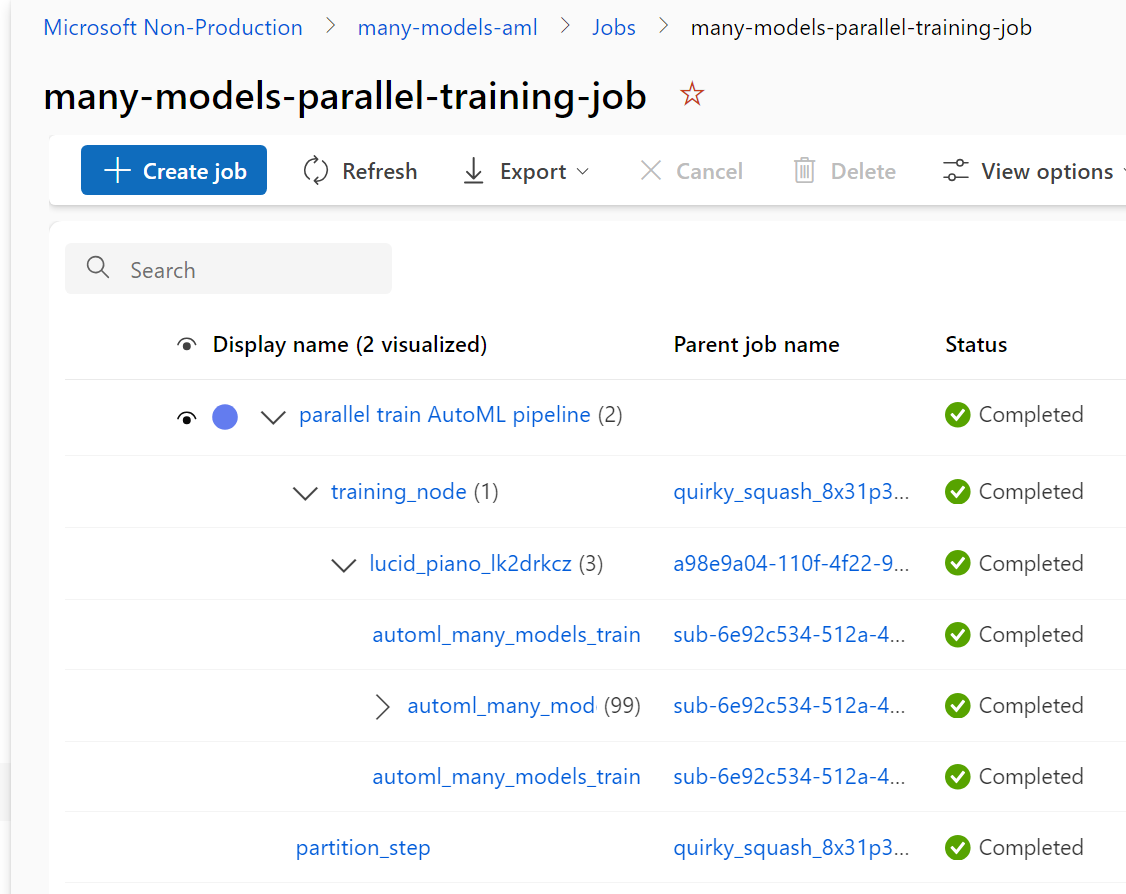

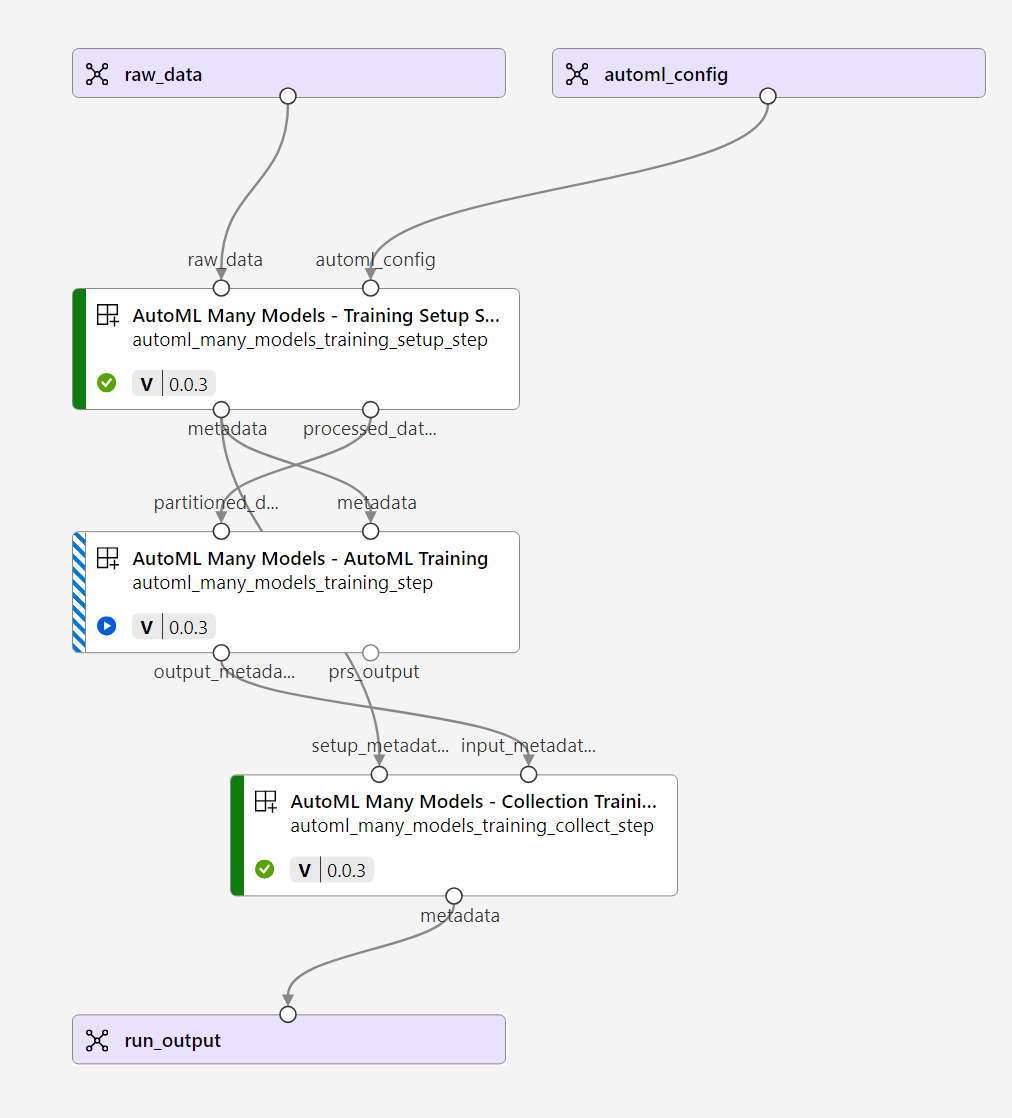

The output for this run is a registered model for each Brand / Store combination. The Brand/Store can be indentified by the model tags